## Add memory to the same agent

In order to add memory to the agent we previously built, we will need to:
-  First, compile the graph with a checkpointer.
-  Second, pass a `config` object to the graph that indicated which thread it is running on.

In [ ]:
# If you want to execute this one in VScode then either create a .env file with property as below
# OPENAI_API_KEY=put your openai key here
# from dotenv import load_dotenv
# load_dotenv()

#then create a virtual env and install:
# pip install langgraph langchain langchain-openai python-dotenv

#If you want to run google colab:
import os
os.environ["OPENAI_API_KEY"] = "put your key here"
#pip install langgraph langchain langchain-openai python-dotenv

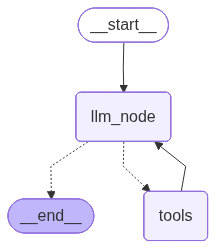

In [ ]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_openai import ChatOpenAI

# define our tools
def multiply(a: float, b: float) -> float:
    """
    Multiply two numbers

    Args:
    a: The first number
    b: The second number
    """
    return a * b

def sum(a: float, b: float) -> float:
    """
    Sum two numbers

    Args:
    a: The first number
    b: The second number
    """
    return a + b

tools = [multiply, sum]

# define our llm and bind the tools
llm = ChatOpenAI(model="gpt-4o-mini")
llm_with_tools = llm.bind_tools(tools)

# node
def llm_node(state: MessagesState):
    response = llm_with_tools.invoke(state["messages"])
    return {"messages": [response]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("llm_node", llm_node)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "llm_node")
builder.add_conditional_edges("llm_node", tools_condition)
builder.add_edge("tools", "llm_node")

graph = builder.compile()

# mermaid graph
display(Image(graph.get_graph().draw_mermaid_png()))


In [ ]:
r = llm.invoke("123213456*498673")

In [ ]:
print(r)

content='The product of 123213456 and 498673 is 61,407,501,048.' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 13, 'total_tokens': 34, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_51db84afab', 'id': 'chatcmpl-CMaenwecAkGQ3Wj2qLrswd1WGlzVF', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None} id='run--b139399e-8d65-41dc-9452-414f5e1ee372-0' usage_metadata={'input_tokens': 13, 'output_tokens': 21, 'total_tokens': 34, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}


In [ ]:
# we compile the graph, but this time, we will use the MemorySaver checkpointer

from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()
graph_with_memory = builder.compile(checkpointer=memory)

In [ ]:
from langchain_core.messages import HumanMessage

messages = [HumanMessage(content="What is 827043 times 16458?")]

# this will not work beacuse we now need a chekpointer
# react_graph_memory.invoke({"messages": messages})

THREAD_ID = "1"

result = graph_with_memory.invoke(
    {"messages": messages},
    config= {
      "configurable": {"thread_id": THREAD_ID}
    }
  )

In [ ]:
for m in result["messages"]:
    m.pretty_print()

================================ Human Message =================================

What is 827043 times 16458?
================================== Ai Message ==================================
Tool Calls:
  multiply (call_vO0NrWZ3Jc3lw1PJdDqjZQSw)
 Call ID: call_vO0NrWZ3Jc3lw1PJdDqjZQSw
  Args:
    a: 827043
    b: 16458
================================= Tool Message =================================
Name: multiply

13611473694.0
================================== Ai Message ==================================

827043 times 16458 is 13,611,473,694.


In [ ]:
messages = [HumanMessage(content="Add 6 to that")]

result = graph_with_memory.invoke(
    {"messages": messages},
    config= {
      "configurable": {"thread_id": THREAD_ID}
    }
  )

In [ ]:
for m in result["messages"]:
    m.pretty_print()

================================ Human Message =================================

What is 827043 times 16458?
================================== Ai Message ==================================
Tool Calls:
  multiply (call_vO0NrWZ3Jc3lw1PJdDqjZQSw)
 Call ID: call_vO0NrWZ3Jc3lw1PJdDqjZQSw
  Args:
    a: 827043
    b: 16458
================================= Tool Message =================================
Name: multiply

13611473694.0
================================== Ai Message ==================================

827043 times 16458 is 13,611,473,694.
================================ Human Message =================================

Add 6 to that
================================== Ai Message ==================================
Tool Calls:
  sum (call_HGCMbZwbY90qNdEGqEhj2wX9)
 Call ID: call_HGCMbZwbY90qNdEGqEhj2wX9
  Args:
    a: 13611473694
    b: 6
================================= Tool Message =================================
Name: sum

13611473700.0
================================== Ai M

In [ ]:
messages = [HumanMessage(content="Add 6 to that")]

result = graph_with_memory.invoke(
    {"messages": messages},
    config= {
      "configurable": {"thread_id": THREAD_ID}
    }
  )

In [ ]:
messages = [HumanMessage(content="Add 6 to that")]

result = graph_with_memory.invoke(
    {"messages": messages},
    config= {
      "configurable": {"thread_id": 2}
    }
  )

In [ ]:
for m in result["messages"]:
    m.pretty_print()

================================ Human Message =================================

Add 6 to that
================================== Ai Message ==================================

Could you please provide the number you would like to add 6 to?


## Summary-based memory in chatbot

Great! Now, let's create a chatbot that can have multiple conversations and remember them. This agent will summarize the conversation messages and send this summary to the agent along with the latest two messages. The agent will then use this information to generate a response.

This will allow you to use LLMs to have longer conversations without having to spend a lot of tokens.

This is getting closer to something that could power an app like ChatGPT. Let's get started!

In [ ]:
# update the MessageState to include a summary key

from langgraph.graph import MessagesState

class State(MessagesState):
    summary: str

In [ ]:
from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage
from langgraph.graph import END

llm = ChatOpenAI(model="gpt-4o-mini")

# define 2 nodes: chat and summarize_conversation

def chat(state: State):
    summary = state.get("summary", "")
    if summary:
        system_prompt = f"Here is the summary of the conversation earlier: {summary}"
        messages = [SystemMessage(content=system_prompt)] + state["messages"]
    else:
        messages = state["messages"]

    response = llm.invoke(messages)
    return {"messages": [response]}

def summarize_conversation(state: State):
    summary = state.get("summary", "")
    if summary:
        summary_prompt = f"""
        This is a summary of the conversation up to this point: {summary}.\n\n
        Extend the summary by taking into account the latest messages above.
        """
    else:
        summary_prompt = "Create a summary of the conversation up to this point."

    messages = state["messages"] + [HumanMessage(content=summary_prompt)]
    response = llm.invoke(messages)

    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": delete_messages}

# conditional edge that sends to summary only of more than 6 messages
def should_summarize(state: State):
    """
    Check if we should summarize the conversation.
    """
    messages = state["messages"]
    if len(messages) > 6:
        return "summarize_conversation"
    return END


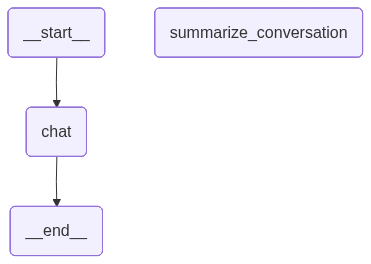

In [ ]:
from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END

builder = StateGraph(State)
builder.add_node(chat)
builder.add_node(summarize_conversation)

builder.add_edge(START, "chat")
builder.add_conditional_edges("chat", should_summarize)
builder.add_edge("summarize_conversation", END)

memory = MemorySaver()
graph = builder.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))




In [ ]:
# think of a thread like a different conversation.
# if this were to power chatGPT, each thread would be a different conversation

THREAD_ID = "1"
config = {
    "configurable": {"thread_id": THREAD_ID}
}

input_message = HumanMessage(content="Hello, My name is Giovanni Giorgio, but everybody calls me Giorgio.")
result = graph.invoke({"messages": [input_message]}, config=config)
for m in result["messages"][-2:]:
    m.pretty_print()




================================ Human Message =================================

Hello, My name is Giovanni Giorgio, but everybody calls me Giorgio.
================================== Ai Message ==================================

Hello, Giorgio! It's nice to meet you. How can I assist you today?


In [ ]:

input_message = HumanMessage(content="What is my name?")
result = graph.invoke({"messages": [input_message]}, config=config)
for m in result["messages"]:
    m.pretty_print()



================================ Human Message =================================

Hello, My name is Giovanni Giorgio, but everybody calls me Giorgio.
================================== Ai Message ==================================

Hello, Giorgio! It's nice to meet you. How can I assist you today?
================================ Human Message =================================

What is my name?
================================== Ai Message ==================================

Your name is Giovanni Giorgio, but you go by Giorgio.


In [ ]:
input_message = HumanMessage(content="Do you know anything about me?")
result = graph.invoke({"messages": [input_message]}, config=config)
for m in result["messages"]:
    m.pretty_print()

================================ Human Message =================================

Hello, My name is Giovanni Giorgio, but everybody calls me Giorgio.
================================== Ai Message ==================================

Hello, Giorgio! It's nice to meet you. How can I assist you today?
================================ Human Message =================================

What is my name?
================================== Ai Message ==================================

Your name is Giovanni Giorgio, but you go by Giorgio.
================================ Human Message =================================

Do you know anything about me?
================================== Ai Message ==================================

I don't have any personal information about you beyond what you've shared. If you'd like to tell me more about yourself or ask questions, feel free!


In [ ]:
# summary is empty because len(messages) < 6

graph.get_state(config).values.get("summary", "")

''

In [ ]:
conversation_history = graph.get_state(config).values.get("messages", [])
for m in conversation_history:
    m.pretty_print()

================================ Human Message =================================

Hello, My name is Giovanni Giorgio, but everybody calls me Giorgio.
================================== Ai Message ==================================

Hello, Giorgio! It's nice to meet you. How can I assist you today?
================================ Human Message =================================

What is my name?
================================== Ai Message ==================================

Your name is Giovanni Giorgio, but you go by Giorgio.
================================ Human Message =================================

Do you know anything about me?
================================== Ai Message ==================================

I don't have any personal information about you beyond what you've shared. If you'd like to tell me more about yourself or ask questions, feel free!


In [ ]:
# the messages have been deleted

new_message = HumanMessage(content="I am a musician and producer.")
result = graph.invoke({"messages": [new_message]}, config=config)
for m in result["messages"]:
    m.pretty_print()

================================ Human Message =================================

I am a musician and producer.
================================== Ai Message ==================================

That’s great to hear, Giorgio! What kind of music do you create or produce, and do you have any specific projects you’re currently working on?


In [ ]:
# but we have a summary now

print(graph.get_state(config).values.get("summary", ""))

Sure! Here’s a summary of our conversation so far:

- You introduced yourself as Giovanni Giorgio but mentioned that everyone calls you Giorgio.
- I acknowledged your name and asked how I could assist you.
- You asked me what your name was, and I confirmed it.
- You inquired if I knew anything about you, and I stated that I only know what you've shared.
- You shared that you are a musician and producer.
- I expressed interest and asked what kind of music you create or produce, as well as if you have any current projects.

Let me know if there's anything else you'd like to add or discuss!


In [ ]:
# let's add more messages

new_message = HumanMessage(content="I was born on April 26, 1940.")
graph.invoke({"messages": [new_message]}, config=config)

{'messages': [HumanMessage(content='I am a musician and producer.', additional_kwargs={}, response_metadata={}, id='fff5e34a-393c-48f0-9443-ddb9ad82e6e6'),
  AIMessage(content='That’s great to hear, Giorgio! What kind of music do you create or produce, and do you have any specific projects you’re currently working on?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 31, 'prompt_tokens': 122, 'total_tokens': 153, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-CMag6N6hp4VIDXVS1b4huBvl30bSE', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--e830fbc1-721e-4634-984d-151bf2fde232-0', usage_metadata={'input_tokens': 122, 'output_tokens': 31, 'total_tokens': 153, 'inpu

In [ ]:
for m in graph.get_state(config).values.get("messages", []):
    m.pretty_print()

================================ Human Message =================================

I am a musician and producer.
================================== Ai Message ==================================

That’s great to hear, Giorgio! What kind of music do you create or produce, and do you have any specific projects you’re currently working on?
================================ Human Message =================================

I was born on April 26, 1940.
================================== Ai Message ==================================

That’s a significant date! It means you have a wealth of life experience and musical history to draw from. How has your journey in music evolved over the years?


In [ ]:
print(graph.get_state(config).values.get("summary", ""))


Sure! Here’s a summary of our conversation so far:

- You introduced yourself as Giovanni Giorgio but mentioned that everyone calls you Giorgio.
- I acknowledged your name and asked how I could assist you.
- You asked me what your name was, and I confirmed it.
- You inquired if I knew anything about you, and I stated that I only know what you've shared.
- You shared that you are a musician and producer.
- I expressed interest and asked what kind of music you create or produce, as well as if you have any current projects.

Let me know if there's anything else you'd like to add or discuss!
